# SRGAN
Notebook to reproduce the results of the SRGAN paper following https://medium.com/analytics-vidhya/super-resolution-gan-srgan-5e10438aec0c 

In [1]:
!git clone https://github.com/vishal1905/Super-Resolution.git

fatal: destination path 'Super-Resolution' already exists and is not an empty directory.


In [1]:
import os
import torch
import torch.nn as n
import torch.nn.functional as f
import numpy as np
import os
from torchsummary import summary
import torch.optim as optim
from tqdm import tqdm
from torchvision import models
import torchvision
import cv2
from matplotlib import pyplot as plt
from PIL import Image

cuda = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
base_dir = "Super-Resolution/celeba-dataset/img_align_celeba/img_align_celeba/"
images = os.listdir(base_dir)
imageList = images[:1500]

## Define generator

In [23]:
class Generator(n.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = n.Conv2d(3,64,9,padding=4,bias=False)
        self.conv2 = n.Conv2d(64,64,3,padding=1,bias=False)
        self.conv3_1 = n.Conv2d(64,256,3,padding=1,bias=False)
        self.conv3_2 = n.Conv2d(64,256,3,padding=1,bias=False)
        self.conv4 = n.Conv2d(64,3,9,padding=4,bias=False)
        self.bn = n.BatchNorm2d(64)
        self.ps = n.PixelShuffle(2)
        self.prelu = n.PReLU()
        
    def forward(self,x):
        block1 = self.prelu(self.conv1(x))
        block2 = torch.add(self.bn(self.conv2(self.prelu(self.bn(self.conv2(block1))))),block1)
        block3 = torch.add(self.bn(self.conv2(self.prelu(self.bn(self.conv2(block2))))),block2)
        block4 = torch.add(self.bn(self.conv2(self.prelu(self.bn(self.conv2(block3))))),block3)
        block5 = torch.add(self.bn(self.conv2(self.prelu(self.bn(self.conv2(block4))))),block4)
        block6 = torch.add(self.bn(self.conv2(self.prelu(self.bn(self.conv2(block5))))),block5)
        block7 = torch.add(self.bn(self.conv2(block6)),block1)
        block8 = self.prelu(self.ps(self.conv3_1(block7)))
        block9 = self.prelu(self.ps(self.conv3_2(block8)))
        block10 = self.conv4(block9)
        return block10

In [24]:
gen = Generator().to(cuda).float()

In [36]:
gen.conv2.weight

Parameter containing:
tensor([[[[ 0.0380,  0.0389,  0.0410],
          [-0.0033, -0.0001, -0.0293],
          [ 0.0231, -0.0327, -0.0193]],

         [[-0.0301,  0.0219, -0.0333],
          [-0.0060,  0.0126, -0.0338],
          [ 0.0024, -0.0181,  0.0071]],

         [[ 0.0370,  0.0284,  0.0203],
          [ 0.0138, -0.0101,  0.0204],
          [ 0.0401,  0.0212,  0.0415]],

         ...,

         [[ 0.0393, -0.0016,  0.0403],
          [-0.0343, -0.0099, -0.0304],
          [ 0.0017,  0.0338,  0.0032]],

         [[ 0.0415,  0.0076, -0.0384],
          [ 0.0382, -0.0052, -0.0313],
          [ 0.0238,  0.0390,  0.0106]],

         [[-0.0189, -0.0009,  0.0010],
          [-0.0071, -0.0266,  0.0270],
          [ 0.0239, -0.0154, -0.0258]]],


        [[[ 0.0037, -0.0053,  0.0375],
          [ 0.0280, -0.0382,  0.0002],
          [ 0.0329,  0.0231, -0.0171]],

         [[-0.0355,  0.0079,  0.0404],
          [-0.0111, -0.0399,  0.0148],
          [ 0.0234, -0.0007, -0.0300]],

         

## Discriminator

In [5]:
# class Discriminator(n.Module):
#     def __init__(self):
#         super().__init__()
#         self.conv1 = n.Conv2d(3,64,3,padding=1,bias=False)
#         self.conv2 = n.Conv2d(64,64,3,stride=2,padding=1,bias=False)
#         self.bn2 = n.BatchNorm2d(64)
#         self.conv3 = n.Conv2d(64,128,3,padding=1,bias=False)
#         self.bn3 = n.BatchNorm2d(128)
#         self.conv4 = n.Conv2d(128,128,3,stride=2,padding=1,bias=False)
#         self.bn4 = n.BatchNorm2d(128)
#         self.conv5 = n.Conv2d(128,256,3,padding=1,bias=False)
#         self.bn5 = n.BatchNorm2d(256)
#         self.conv6 = n.Conv2d(256,256,3,stride=2,padding=1,bias=False)
#         self.bn6 = n.BatchNorm2d(256)
#         self.conv7 = n.Conv2d(256,512,3,padding=1,bias=False)
#         self.bn7 = n.BatchNorm2d(512)
#         self.conv8 = n.Conv2d(512,512,3,stride=2,padding=1,bias=False)
#         self.bn8 = n.BatchNorm2d(512)
#         self.fc1 = n.Linear(512*16*16,1024)
#         self.fc2 = n.Linear(1024,1)
#         self.drop = n.Dropout2d(0.3)
        
#     def forward(self,x):
#         block1 = f.leaky_relu(self.conv1(x))
#         block2 = f.leaky_relu(self.bn2(self.conv2(block1)))
#         block3 = f.leaky_relu(self.bn3(self.conv3(block2)))
#         block4 = f.leaky_relu(self.bn4(self.conv4(block3)))
#         block5 = f.leaky_relu(self.bn5(self.conv5(block4)))
#         block6 = f.leaky_relu(self.bn6(self.conv6(block5)))
#         block7 = f.leaky_relu(self.bn7(self.conv7(block6)))
#         block8 = f.leaky_relu(self.bn8(self.conv8(block7)))
#         block8 = block8.view(-1,block8.size(1)*block8.size(2)*block8.size(3))
#         block9 = f.leaky_relu(self.fc1(block8),)
#         block10 = torch.sigmoid(self.drop(self.fc2(block9)))
#         return block9,block10
    
class Discriminator(n.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = n.Conv2d(3,32,3,padding=1,bias=False)
        self.conv2 = n.Conv2d(32,32,3,stride=2,padding=1,bias=False)
        self.bn2 = n.BatchNorm2d(32)
        self.conv3 = n.Conv2d(32,64,3,padding=1,bias=False)
        self.bn3 = n.BatchNorm2d(64)
        self.conv4 = n.Conv2d(64,64,3,stride=2,padding=1,bias=False)
        self.bn4 = n.BatchNorm2d(64)
        self.conv5 = n.Conv2d(64,128,3,padding=1,bias=False)
        self.bn5 = n.BatchNorm2d(128)
        self.conv6 = n.Conv2d(128,128,3,stride=2,padding=1,bias=False)
        self.bn6 = n.BatchNorm2d(128)
        self.conv7 = n.Conv2d(128,256,3,padding=1,bias=False)
        self.bn7 = n.BatchNorm2d(256)
        self.conv8 = n.Conv2d(256,256,3,stride=2,padding=1,bias=False)
        self.bn8 = n.BatchNorm2d(256)
        self.conv9 = n.Conv2d(256,256,3,stride=2,padding=1,bias=False)
        self.bn9 = n.BatchNorm2d(256)
        self.conv10 = n.Conv2d(256,256,3,stride=2,padding=1,bias=False)
        self.bn10 = n.BatchNorm2d(256)
        self.fc1 = n.Linear(256*4*4,256)
        self.fc2 = n.Linear(256,1)
        self.drop = n.Dropout2d(0.3)
        
    def forward(self,x):
        block1 = f.leaky_relu(self.conv1(x))
        block2 = f.leaky_relu(self.bn2(self.conv2(block1)))
        block3 = f.leaky_relu(self.bn3(self.conv3(block2)))
        block4 = f.leaky_relu(self.bn4(self.conv4(block3)))
        block5 = f.leaky_relu(self.bn5(self.conv5(block4)))
        block6 = f.leaky_relu(self.bn6(self.conv6(block5)))
        block7 = f.leaky_relu(self.bn7(self.conv7(block6)))
        block8 = f.leaky_relu(self.bn8(self.conv8(block7)))
        block9 = f.leaky_relu(self.bn9(self.conv9(block8)))
        block10 = f.leaky_relu(self.bn10(self.conv10(block9)))
        block10 = block10.view(-1,block10.size(1)*block10.size(2)*block10.size(3))
        block11 = f.leaky_relu(self.fc1(block10),)
        block12 = torch.sigmoid(self.drop(self.fc2(block11)))
        return block11,block12

In [27]:
512*16*16*1024

134217728

In [6]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [7]:
disc = Discriminator().to(cuda).float()

In [8]:
256*4*4*256

1048576

In [9]:
count_parameters(gen), count_parameters(disc)

(363009, 3402913)

## Setup training

In [10]:
vgg = models.vgg19(pretrained=True).to(cuda)

### Losses

In [11]:
gen_loss = n.BCELoss()
vgg_loss = n.MSELoss()
mse_loss = n.MSELoss()
disc_loss = n.BCELoss()

In [12]:
gen_optimizer = optim.Adam(gen.parameters(),lr=0.0001)
disc_optimizer = optim.Adam(disc.parameters(),lr=0.0001)

### Load images

### New image loaders

In [13]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = checkpoint['model']
    model.load_state_dict(checkpoint['state_dict'])
    for parameter in model.parameters():
        parameter.requires_grad = False 
    model.eval()
    return model

In [14]:
def imagePostProcess(imagedir, modelPath):
    """
    Show model output on unseen images 
    Parameters:
    ----------
    imagedir: str
        List of paths to unseen images
    
    """
    imagelist=[]
    original_images = []
    for img in imagedir:
        img_original = cv2.imread(os.path.join(hr_path,img))
        img_original = cv2.resize(img_original, (256,256))
        img = degrade_resolution(img_original)
        imagelist.append(img)
        original_images.append(img_original)
    original_images = np.array(original_images)
    imagearray = np.array(imagelist)/255
    imagearrayPT = np.moveaxis(imagearray,3,1)

    model = load_checkpoint(modelPath)
    im_tensor = torch.from_numpy(imagearrayPT).float()
    out_tensor = model(im_tensor)
    out = out_tensor.numpy()
    out = np.moveaxis(out,1,3)
    out = np.clip(out,0,1)
    
    return original_images, imagearray, out

In [15]:
def show_samples(image_dir, model_path):

    # Load images and run through
    original_images, low_res, out = imagePostProcess(image_dir, model_path)

    # Get the number of samples to plot
    n_samples = len(image_dir)
    figure, axes = plt.subplots(n_samples, 3)
    for i in range(n_samples):
        axes[i,0].imshow(original_images[i,...][...,::-1])

    for i in range(n_samples):
        axes[i,1].imshow(low_res[i,...][...,::-1])

    for i in range(n_samples):
        axes[i,2].imshow(out[i,...][...,::-1])
    plt.axis("off")
    plt.show()
    plt.close()

In [16]:
def degrade_resolution(image):
    """
    Degrade image resolution
    """
    resized = cv2.resize(cv2.GaussianBlur(image,(5,5),cv2.BORDER_DEFAULT),(64,64)) 
    return resized

In [17]:
class Dataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'

  def __init__(self, image_list):
        'Initialization'
        self.image_list = image_list
        self.base_dir = "Super-Resolution/celeba-dataset/img_align_celeba/img_align_celeba/"

  def __len__(self):
        return len(self.image_list)

  def __getitem__(self, index):
        # Select sample
        image_file = self.image_list[index]

        # Load the original (high res) image
        high_res = cv2.imread(self.base_dir+image_file)
        high_res = cv2.resize(high_res, (256,256))

        # Degrade to low res
        low_res = degrade_resolution(high_res)

        # Normalise
        high_res = torch.from_numpy(high_res/255)
        low_res = torch.from_numpy(low_res/255)

        # Channels to second dim
        high_res = high_res.permute(2,0,1)
        low_res = low_res.permute(2,0,1)

        return low_res.cuda().float(), high_res.cuda().float()

In [18]:
image_dataset = Dataset(imageList)

In [19]:
training_generator = torch.utils.data.DataLoader(image_dataset,
                                                 shuffle = True,
                                                 batch_size = 32
                                                )

In [20]:
import os 
base_path = os.getcwd()

#lr_path = os.path.join(base_path,"trainImages")
hr_path = base_dir
#valid_path = os.path.join(base_path,"SR_valid")
weight_file = os.path.join(base_path,"SRPT_weights")
out_path = os.path.join(base_path,"out")

if not os.path.exists(weight_file):
    os.makedirs(weight_file)

if not os.path.exists(out_path):
    os.makedirs(out_path)


In [22]:
X, y = next(iter(training_generator))
X.shape, y.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32, 3, 256, 256]))

100%|██████████| 47/47 [04:10<00:00,  5.32s/it]
/anaconda/envs/nwp-downscale/lib/python3.8/site-packages/torch/serialization.py:359: UserWarning: Couldn't retrieve source code for container of type Generator. It won't be checked for correctness upon loading.
  warnings.warn("Couldn't retrieve source code for container of "


d1_loss: 0.28408067340546467  d2_loss:0.2879347864617693
genLoss: 3.7824218564845147  vggLoss: 0.19164244703789976  MeanLoss: 0.06993580563984653


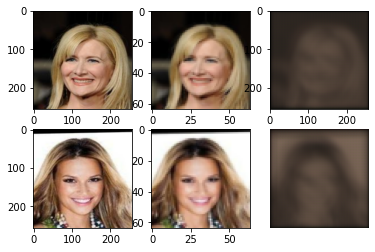

  0%|          | 0/47 [00:05<?, ?it/s]


KeyboardInterrupt: 

In [21]:
#batch_count=60
epochs = 100

for epoch in range(epochs):
    d1loss_list=[]
    d2loss_list=[]
    gloss_list=[]
    vloss_list=[]
    mloss_list=[]
    
    for lr_images, hr_images in tqdm(training_generator):
                
        disc.zero_grad()

        gen_out = gen(lr_images)
        _,f_label = disc(gen_out)
        _,r_label = disc(hr_images)

        d1_loss = (disc_loss(f_label,torch.zeros_like(f_label,dtype=torch.float)))
        d2_loss = (disc_loss(r_label,torch.ones_like(r_label,dtype=torch.float)))
        d2_loss.backward()
        d1_loss.backward(retain_graph=True)
        disc_optimizer.step()

        gen.zero_grad()      
        g_loss = gen_loss(f_label.data,torch.ones_like(f_label,dtype=torch.float))
        v_loss = vgg_loss(vgg.features[:7](gen_out),vgg.features[:7](hr_images))
        m_loss = mse_loss(gen_out,hr_images)
        
        generator_loss = g_loss + v_loss + m_loss
        generator_loss.backward()
        gen_optimizer.step()
        
        d1loss_list.append(d1_loss.item())
        d2loss_list.append(d2_loss.item())
        
        gloss_list.append(g_loss.item())
        vloss_list.append(v_loss.item())
        mloss_list.append(m_loss.item())

    print("d1_loss: "+str(np.mean(d1loss_list))+"  d2_loss:"+str(np.mean(d2loss_list)))
    print("genLoss: "+str(np.mean(gloss_list))+"  vggLoss: "+str(np.mean(vloss_list))+"  MeanLoss: "+str(np.mean(mloss_list)))
    
    if(epoch%3==0):
        
        checkpoint = {'model': Generator(),
              'input_size': 64,
              'output_size': 256,
              'state_dict': gen.state_dict()}
        torch.save(checkpoint,os.path.join(weight_file,"SR"+str(epoch+1)+".pth"))
        torch.cuda.empty_cache()
        
        show_samples(images[-2:],os.path.join(weight_file,"SR"+str(epoch+1)+".pth"))